In [1]:
# 高斯核生成函数(最简版)
def creat_gauss_kernel(kernel_size=3, sigma=1, k=1):
    if sigma == 0:
        sigma = ((kernel_size - 1) * 0.5 - 1) * 0.3 + 0.8
    X = np.linspace(-k, k, kernel_size)
    Y = np.linspace(-k, k, kernel_size)
    x, y = np.meshgrid(X, Y)
    x0 = 0
    y0 = 0
    gauss = 1/(2*np.pi*sigma**2) * np.exp(- ((x -x0)**2 + (y - y0)**2)/ (2 * sigma**2))
    return gauss


In [2]:
import numpy as np
import  cv2 as cv
 
 
def generate_kernel(sigma1,sigma2,theta,loc):
    '''ArithmeticError
        sigma1: variance of distribution 1
        sigma2: variance of distribution 2,当sigma1=sigma2是各向同性，反之为各向异性
        theta: 旋转角
        loc: 高斯核坐标 (-loc,loc)
        
    '''
    # 计算标准协方差矩阵
    thetaMatrix=np.dot(np.matrix([[sigma1**2,0],[0,sigma2**2]]),np.identity(2))
    
    # 旋转矩阵
    rotationMatrix=np.matrix([[np.cos(theta*np.pi/180),-1*np.sin(theta*np.pi/180)],
                              [np.sin(theta*np.pi/180),np.cos(theta*np.pi/180)]])
    # 协方差矩阵
    covMatrix=np.dot(np.dot(rotationMatrix,thetaMatrix),rotationMatrix.transpose())
    # 高斯核在loc位置的值
    k_value=np.exp(-0.5*np.dot(np.dot(loc.transpose(),np.linalg.inv(covMatrix)),loc))
    return k_value 


# 1 根据公式产生各向异性高斯核

传入参数：sigma1 , alpha (sigma2)

后面还要采样，比较麻烦

https://www.cnblogs.com/klitech/p/6144670.html


In [2]:
from typing import Any
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from math import *
import torch.nn.functional as F


class anisotopicGaussianKernel(object):
    """
    Generate anisotopic gauss kernel
    Args:
        sigma(float):the var of distribution 1
        alpha(float): the ratio between width and length of gauss,best smaller than 1.0 (sigma2 = sigma x alpha)
        theta(float): the angle of gaussian
        kernel_size(float): kernel size of Gaussian
    Output:
        kernel: tensor(kernel_size x kernel_size)
    """
    def __init__(self,sigma=1.0,alpha=1.0,theta=90,kernel_size=5) -> None:
        self.sigma = sigma
        self.alpha = alpha
        self.theta = theta
        self.kernel_size = kernel_size
    
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        # generate value  of x,y as grid of kernel size
        x, y = np.meshgrid(np.linspace(-self.kernel_size, self.kernel_size, self.kernel_size),
                          np.linspace(-self.kernel_size, self.kernel_size, self.kernel_size))
        
        # compute distance
        dst_x = np.sqrt((x*cos(self.theta)+y*sin(self.theta))**2)
        dst_y = np.sqrt((-x*sin(self.theta)+y*cos(self.theta))**2)
        
        # lower normal part of gaussian
        normal = (1/sqrt(2.0 * np.pi * self.sigma**2))*(1/sqrt(2.0 * np.pi * (self.sigma*self.alpha)**2))
        
        # Calculating Gaussian filter
        kernel = np.exp(-((dst_x)**2 / (2.0 * self.sigma**2))-((dst_y)**2 / (2.0 * (self.sigma*self.alpha)**2))) * normal
        kernel = kernel/kernel.sum()
        
        return kernel
        
    

/home/kzy/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
kernel_size = 10
gauss = anisotopicGaussianKernel(kernel_size=kernel_size,sigma=10,alpha=0.5)
kernel = gauss()
kernel

array([[0.00053031, 0.00135513, 0.00292797, 0.00534914, 0.00826288,
        0.0107922 , 0.01191845, 0.01112911, 0.00878683, 0.0058659 ],
       [0.00095052, 0.00228899, 0.00466075, 0.00802417, 0.01168085,
        0.0143774 , 0.01496294, 0.01316693, 0.00979677, 0.00616329],
       [0.0015741 , 0.00357225, 0.00685459, 0.01112121, 0.01525645,
        0.01769645, 0.01735601, 0.01439277, 0.01009183, 0.0059831 ],
       [0.00240846, 0.00515081, 0.00931413, 0.01424098, 0.01841062,
        0.02012464, 0.01860024, 0.01453584, 0.00960489, 0.00536631],
       [0.00340473, 0.00686192, 0.01169335, 0.01684859, 0.0205267 ,
        0.0211449 , 0.01841718, 0.01356349, 0.008446  , 0.00444694],
       [0.00444694, 0.008446  , 0.01356349, 0.01841718, 0.0211449 ,
        0.0205267 , 0.01684859, 0.01169335, 0.00686192, 0.00340473],
       [0.00536631, 0.00960489, 0.01453584, 0.01860024, 0.02012464,
        0.01841062, 0.01424098, 0.00931413, 0.00515081, 0.00240846],
       [0.0059831 , 0.01009183, 0.0143927

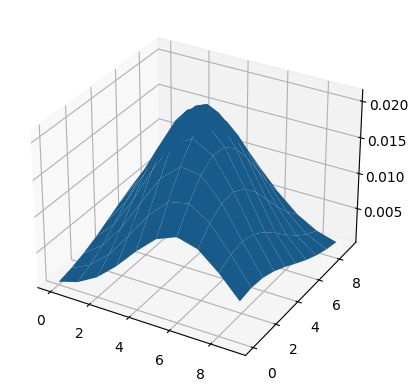

In [8]:
# 绘图
Y = np.arange(0,kernel_size, 1)
X = np.arange(0, kernel_size, 1)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, kernel)
plt.show()

# 2 使用 Numpy 产生高斯随机数

传入参数：协方差矩阵，通过协方差矩阵控制
$$
 \left[
 \begin{matrix}
   \sigma(x_1,x_1) & \sigma(x_1,x_2)  \\
   \sigma(x_2,x_1) & \sigma(x_2,x_2)   \\
  \end{matrix}
  \right] \tag{3}
$$

https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html

In [26]:
import numpy as np


In [27]:
pts = np.random.uniform(-45,45,100)

In [28]:
pts

array([ 3.73555280e+01, -2.07112080e+01,  2.75010559e-01, -2.60851505e+01,
        1.39060552e+00, -4.22669175e+01, -2.73846373e+01, -3.31554946e+01,
        2.69223624e+01,  8.58504525e+00,  6.87660829e+00, -2.61890721e+01,
       -7.13700017e+00,  1.68070124e+01,  2.38057694e+01, -2.61851699e+01,
       -2.50234967e+01, -3.67430158e+01,  4.24936599e+01, -3.45593987e+01,
        1.88938936e+01,  3.51560881e+01,  1.45909886e+01, -7.16264192e+00,
       -4.31305466e+01,  3.85926782e+00, -3.94589905e+01,  3.41333421e+01,
       -2.27755065e+01, -1.30278472e+01, -1.41737004e+01, -4.39413262e+01,
        3.92341453e+01, -2.21121629e+01,  1.00082958e+01, -4.18469951e+01,
        1.07274582e+00,  4.11809317e+01, -2.10784562e+01,  3.77421642e+01,
       -4.14486484e+01, -1.76511202e+01, -2.71045714e+01,  4.25293432e+01,
        1.07104304e+01, -2.64743305e+01,  2.76414011e+01, -1.44188126e+01,
       -3.00791688e+01,  5.55328998e+00, -1.58227119e+01,  8.23841786e+00,
        3.53151200e+01, -

In [31]:
sigma1**2*block_size

500.0

[[1. 0.]
 [0. 1.]]


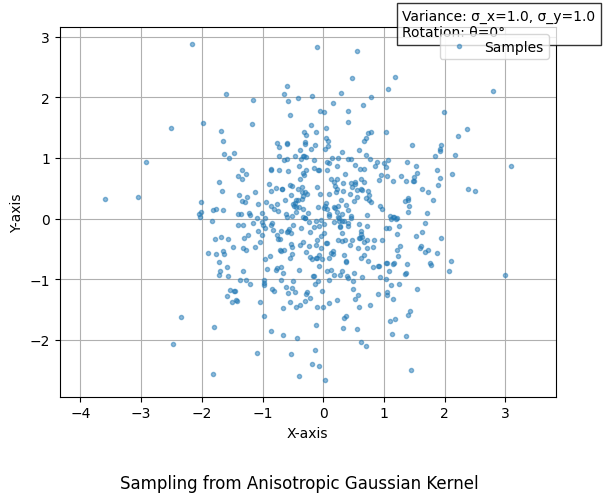

In [ ]:
import numpy as np

sigma1 = 1.0
ratio = 1
sigma2 = sigma1 * ratio
block_size = 500
# theta = np.random.uniform(-45,45)
theta = 0

scalarMatrix = np.matrix([[sigma1**2,0],[0,sigma2**2]])

print(scalarMatrix)

scalarMatrix=np.dot(scalarMatrix,np.identity(2))

# 旋转矩阵
rotationMatrix=np.matrix([[np.cos(theta*np.pi/180),-1*np.sin(theta*np.pi/180)],
                              [np.sin(theta*np.pi/180),np.cos(theta*np.pi/180)]])
        
        # 协方差矩阵
covMatrix=np.dot(np.dot(rotationMatrix,scalarMatrix),rotationMatrix.transpose())

# 产生随机数
pts = np.random.multivariate_normal([0, 0], covMatrix, size=block_size)  

# pts = pts * block_size // 2
# print(pts)

# 绘图
import matplotlib.pyplot as plt
plt.plot(pts[:, 0], pts[:, 1], '.', alpha=0.5, label="Samples")
plt.axis('equal')
plt.grid()
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
# 添加图注（方差和旋转角度）
# text_str = f"Variance: σ_x={sigma1}, σ_y={sigma2}\nRotation: θ={theta}°"
plt.text( 1.3, 3, text_str, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.figtext(0.5, -0.08, "Variance: σ_x={sigma1}, σ_y={sigma2}\nRotation: θ={theta}°", ha="center", fontsize=12)

plt.legend()
plt.show()

In [50]:
import torch.nn as nn

In [11]:
class GaussianDrop2D(nn.Module):
    """
    Generate Corvirance Matrix and use Numpy to generate random numbers
    Args:
        sigma1(float): the var of distribution 1
        sgima2(float): the var of distribution 1
        theta(float): the angle of gaussian
        
    Output:
        kernel: tensor(kernel_size x kernel_size)
    
    PS: 协方差矩阵 Σ = R * S * S * R^-1, 根据 协方差的几何意义, R 为旋转矩阵, S 为 sqrt(L), 其中 L 为尺度矩阵
    
    """
    def __init__(self,sigma1=1.0,sigma2=1.0,theta=90,drop_prob=0.7,block_size=7) -> None:
        super(GaussianDrop2D,self).__init__()
        
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.theta = theta
        self.drop_prob = drop_prob
        self.block_size = block_size
        # self.count = count
    
    def forward(self,x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"
        
        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # 在图像上随机选取中心点
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # 生成各向异性高斯随机数，产生不规则掩膜区域
            # compute block mask, make mask around the center point
            block_mask = self._compute_gaussian_mask(mask,x.shape[1],x.shape[0])

            # apply block mask
            out = x * block_mask

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out
    
    def _compute_gaussian_mask(self,mask,planes,batch):
        '''
        为 batch 图像生成 一个 batch 的 Mask
        
        return block_mask[b,c,w,h]
        '''
        # 复制堆叠副本
        stack_mask = mask.repeat(batch,planes,1,1)
        
        # 为每个通道生成单独的卷积核 kernels[out_channels,inplanes//groups=1,H,W]
        kernels = self._compute_gaussian_kernels(planes) 
        # kernels = [self._compute_gaussian_kernels(planes) for _ in range(batch)]
        # kernels = torch.stack(kernels,dim=0)
        
        # 每个通道单独卷积
        block_mask = F.conv2d(stack_mask,weight=kernels.unsqueeze(1),padding=kernels.shape[-1]//2,stride=1,groups=planes)
        print(block_mask) 
        
        # 取反
        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask
        
        return block_mask
    
    def _compute_gaussian_kernels(self,planes):
        '''
        为一副图像的每个通道生成 kernel,然后堆叠
        
        return : kernels [1,c,h,w]
        '''
        kernels = [self._compute_gaussian_kernel() for _ in range(planes)]
        kernels = torch.stack(kernels)
        return kernels
    
    
    def _compute_gaussian_kernel(self):
        '''
        生成一个二维高斯 Kernel 
        
        return kernel[w,h]
        '''
            
        # 尺度矩阵
        thetaMatrix=np.dot(np.matrix([[self.sigma1**2,0],[0,self.sigma2**2]]),np.identity(2))
    
        # 旋转矩阵
        rotationMatrix=np.matrix([[np.cos(self.theta*np.pi/180),-1*np.sin(self.theta*np.pi/180)],
                              [np.sin(self.theta*np.pi/180),np.cos(self.theta*np.pi/180)]])
        
        # 协方差矩阵
        covMatrix=np.dot(np.dot(rotationMatrix,thetaMatrix),rotationMatrix.transpose())
        
        # 产生随机数
        pts = np.random.multivariate_normal([0, 0], covMatrix, size=self.block_size * self.block_size)
        print(pts)
               
        # 产生坐标
        X = torch.Tensor(pts[:,0])
        Y = torch.Tensor(pts[:,1])   
        # 向量拼接
        locs = torch.stack((X,Y),dim=1)
        
        # 尺度缩放与平移
        # locs = (locs * sqrt(self.block_size)).int() + self.block_size
        locs = (locs).int() + self.block_size // 2
        
        # 限定到 Kernel 范围内
        locs = [_loc for _loc in locs if _loc[0] >= 0 and _loc[0] < self.block_size and _loc[1] >= 0 and _loc[1] < self.block_size]
        
        # 创建kernel
        kernel = torch.zeros((self.block_size,self.block_size))
        
        # 为 kernel 赋值
        for _loc in locs:
            kernel[tuple(_loc)] = 1
        
        return torch.tensor(kernel)
    
    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

In [9]:
from typing import Any
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from math import *
import torch.nn.functional as F
import torch
from torch import nn
from PIL import Image

/home/kzy/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


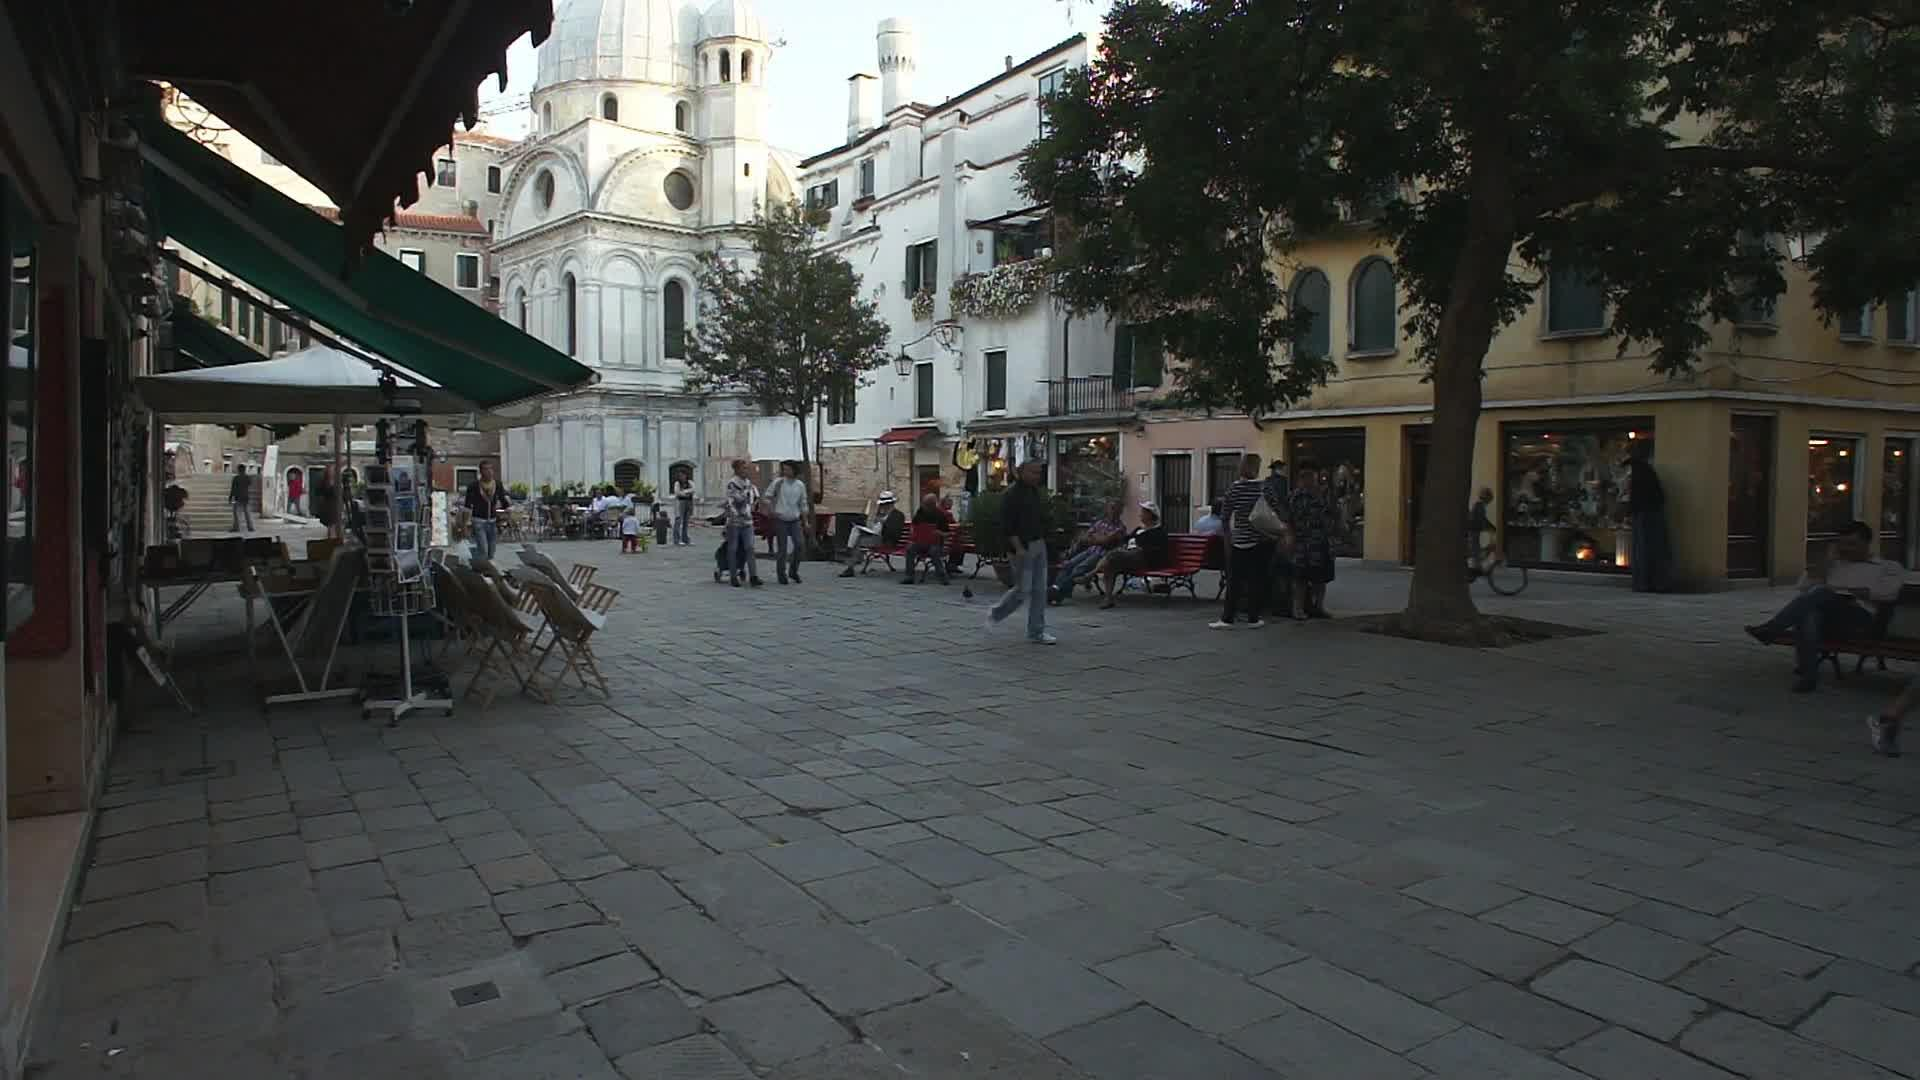

[[-0.3700133  -1.27028272]
 [-1.28136601  0.58813974]
 [-0.64050535 -0.08155054]
 [-1.17341764 -0.72345134]
 [-0.94263958 -3.27955177]
 [-0.0227068   1.58818587]
 [ 0.52313945  1.3875645 ]
 [-0.96228745 -2.07272279]
 [-1.17735867 -0.91361538]
 [ 1.15219717  0.56647592]
 [ 0.50855994  1.36019834]
 [-0.44735946  0.25322745]
 [ 0.98254258  1.29997693]
 [-1.37053826  1.34836311]
 [-1.29501203  1.30670211]
 [-0.91660314 -1.73282788]
 [ 1.01834611  1.57432892]
 [ 0.10204313  0.48142525]
 [-0.04766035  1.56421819]
 [-0.58829192  0.34594781]
 [ 1.11080567 -1.37028007]
 [ 1.63199595  0.62069259]
 [ 1.09466284 -1.81232955]
 [-0.25718347  1.91151986]
 [-0.44924745  0.4567008 ]
 [ 0.74371228 -2.02959913]
 [-0.52821392 -0.61002771]
 [ 0.50484691  1.23514104]
 [-0.36954558 -0.98869704]
 [ 0.65275345  0.62749132]
 [-1.05265691 -1.13724835]
 [-0.68395681 -1.31519578]
 [-0.02308084  1.75193864]
 [-0.90112966 -0.48061309]
 [ 1.17657061  0.82937215]
 [ 0.71160165 -0.63514274]
 [ 1.28314774  1.93218188]
 

/tmp/ipykernel_2487311/804308550.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(kernel)


In [12]:
img = Image.open('/home/kzy/project/Remote-BoT-SORT/datasets/MOT17/test/MOT17-01-FRCNN/img1/000001.jpg')
img.show()
trans = transforms.Compose([transforms.ToTensor(),
                transforms.Resize(256),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) 
img = trans(img)
img1 = img.unsqueeze(0)
    # img1.shape
g = GaussianDrop2D()
img2 = g.forward(img1)

In [ ]:
from PIL import Image
img = Image.open('/home/kzy/project/Remote-BoT-SORT/datasets/MOT17/test/MOT17-01-FRCNN/img1/000001.jpg')
img.show()
trans = transforms.Compose([transforms.ToTensor(),
			 transforms.Resize(256),
			 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) 
img = trans(img)
img1 = img.unsqueeze(0)
img1.shape
g = GaussianDrop2D()
img2 = g.forward(img1)

In [4]:
pts = np.random.multivariate_normal([0, 0], [[1,1],[1,1]], 5,5)

ValueError: check_valid must equal 'warn', 'raise', or 'ignore'